In [2]:
# SETUP

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xarray as xr
from sklearn.model_selection import StratifiedShuffleSplit

import shap
import re

sns.set('paper', style='whitegrid')

/Users/morteza/micromamba/envs/acnets/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/morteza/micromamba/envs/acnets/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta

In [3]:
INPUT_FILENAME = 'connectivity_classifier-SVM_measure-accuracy_cv-5x4fold'

RESULTS = xr.open_dataset('models/' + INPUT_FILENAME + '.nc5').load()

In [4]:
RESULTS

<xarray.Dataset>
Dimensions:                                                                       (
                                                                                   shap_dim: 40,
                                                                                   dosenbach2010_kind-partialcorrelation_feature: 21,
                                                                                   dosenbach2010_kind-precision_feature: 21,
                                                                                   dosenbach2010_kind-correlation_feature: 21,
                                                                                   dosenbach2010_kind-tangent_feature: 21,
                                                                                   ...
                                                                                   permutation_importance_num: 25,
                                                                                   network_model_name: 5,
                                                                                   permutation_dim: 10,
                                                                                   cv_dim: 5,
                                                                                   learning_curve_index: 5,
                                                                                   y_classes: 2)
Coordinates:
  * index                                                                         (index) int32 ...
  * dosenbach2010_kind-partialcorrelation_feature                                 (dosenbach2010_kind-partialcorrelation_feature) object ...
  * dosenbach2010_kind-precision_feature                                          (dosenbach2010_kind-precision_feature) object ...
  * dosenbach2010_kind-correlation_feature                                        (dosenbach2010_kind-correlation_feature) object ...
  * dosenbach2010_kind-tangent_feature                                            (dosenbach2010_kind-tangent_feature) object ...
  * dosenbach2010_kind-covariance_feature                                         (dosenbach2010_kind-covariance_feature) object ...
  * network_model_name                                                            (network_model_name) object ...
  * learning_curve_index                                                          (learning_curve_index) int32 ...
  * y_classes                                                                     (y_classes) object ...
Dimensions without coordinates: shap_dim, subject, permutation_importance_num,
                                permutation_dim, cv_dim
Data variables: (12/50)
    dosenbach2010_kind-partialcorrelation_tsagg-network_connagg-none shap         (shap_dim, dosenbach2010_kind-partialcorrelation_feature) float64 ...
    dosenbach2010_kind-partialcorrelation_tsagg-network_connagg-none shap data    (shap_dim, dosenbach2010_kind-partialcorrelation_feature) float64 ...
    dosenbach2010_kind-precision_tsagg-network_connagg-none shap                  (shap_dim, dosenbach2010_kind-precision_feature) float64 ...
    dosenbach2010_kind-precision_tsagg-network_connagg-none shap data             (shap_dim, dosenbach2010_kind-precision_feature) float64 ...
    dosenbach2010_kind-correlation_tsagg-network_connagg-none shap                (shap_dim, dosenbach2010_kind-correlation_feature) float64 ...
    dosenbach2010_kind-correlation_tsagg-network_connagg-none shap data           (shap_dim, dosenbach2010_kind-correlation_feature) float64 ...
    ...                                                                            ...
    permutation_test_scores                                                       (network_model_name, permutation_dim) float64 ...
    permutation_test_cv_scores                                                    (network_model_name, cv_dim) float64 ...
    permutation_test_pvalue                                                       (n

In [5]:
# prep grid data

n_subjects = RESULTS['X'].size
X = RESULTS['X'].values
y = RESULTS['y'].values
cv_n_splits = RESULTS['cv_dim'].size
cv_test_size = 8 # TODO RESULTS['cv_test_size'].item()
scoring = 'accuracy' # RESULTS['scoring'].item()


score_cols = [c for c in list(RESULTS.keys()) if re.match(r'split\d+_test_score', c)]

scores = RESULTS[score_cols +
                 ['rank_test_score', 'mean_test_score', 'model_name']].to_pandas()

# scores['label'] = scores['params'].apply(lambda p: ' '.join(p.values()))
scores['test_score'] = scores[score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)

scores['atlas'] = scores['model_name'].apply(lambda x: x.split('_')[0])
scores['kind'] = scores['model_name'].apply(lambda x: x.split('_')[1].replace('kind-',''))

scores = scores[['model_name', 'atlas', 'kind', 'test_score', 'mean_test_score']]

scores = scores.query('model_name.str.contains("tsagg-network_connagg-none")')

# simulate chance
chance_scores = {}
for model_name in scores['model_name'].unique():
    chance_model = DummyClassifier(strategy='stratified').fit(X, y)
    _chance_scores = cross_val_score(chance_model, X, y,
                                     cv=StratifiedShuffleSplit(n_splits=cv_n_splits, test_size=cv_test_size), scoring=scoring)
    chance_scores[model_name] = _chance_scores

chance_scores = pd.DataFrame(chance_scores)
chance_scores = chance_scores.melt(value_name=scoring, var_name='model_name')

# sort, mean score and ordering
scores = scores.sort_values('mean_test_score', ascending=True)
mean_scores = scores.groupby('model_name')[['test_score']].mean().reset_index()
order = scores['model_name'].drop_duplicates()

# percentage accuracy
scores['accuracy_pct'] = scores['test_score'] * 100.0
chance_scores['accuracy_pct'] = chance_scores['accuracy'] * 100.0
mean_scores['accuracy_pct'] = mean_scores['test_score'] * 100.0


In [6]:
# Calculate and report 95% confidence intervals

from scipy.stats import bootstrap
import numpy as np

def calculate_ci(scores):
    bootstrap_ci = bootstrap((scores.values,), np.mean, confidence_level=0.95, method='percentile')

    return bootstrap_ci.confidence_interval.low, bootstrap_ci.confidence_interval.high


scores.groupby(['atlas','kind'])['accuracy_pct'].apply(calculate_ci)

atlas          kind              
dosenbach2010  correlation           (52.5, 67.5)
               covariance            (40.0, 65.0)
               partialcorrelation    (47.5, 77.5)
               precision             (52.5, 67.5)
               tangent               (50.0, 67.5)
Name: accuracy_pct, dtype: object

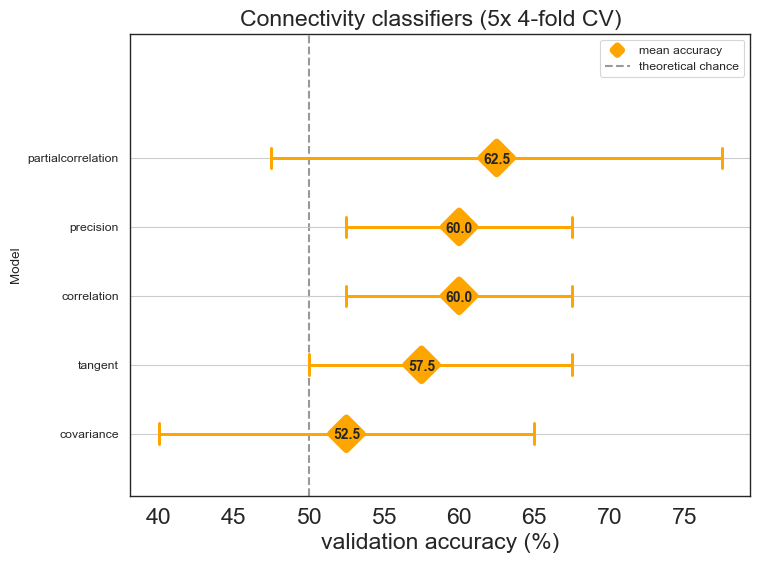

In [30]:
sns.set('paper', 'white')
_, ax = plt.subplots(figsize=(8, 12 * .5))

# observation
g = sns.pointplot(data=scores,
              x='accuracy_pct', y='model_name', order=order,
              join=False,
              color='orange',
              markers='D',
              capsize=0.3,
              scale=3,
              # cmap='viridis',
              # plot_kws=dict(zorder=1),
              ax=ax,
              label='mean accuracy')

# annotate the mean points
y_ticklabels = [t.get_text() for t in ax.get_yticklabels()]
for i, model_name, cv_test_score, accuracy_pct in mean_scores.itertuples():
    ticklabel_idx = y_ticklabels.index(model_name)
    ax.annotate(f'{accuracy_pct:.1f}', (accuracy_pct-.9, ticklabel_idx-.08), weight='bold', size=10)

ax.grid(axis='y')
ax.axvline(x=50, linestyle='--', color='gray', linewidth=1.5, alpha=.8, label='theoretical chance', zorder=-1)

# update model names (y-axis tick labels)
ax.set_yticklabels([l.split('_')[1].replace('kind-','') for l in y_ticklabels])

# motion confounds clasifier
# ax.scatter([51.4], [-.7], marker='^', s=160, color='gray')

ax.set(ylabel='Model', ylim=(-.9, len(order)+.8))
ax.set_xlabel('validation accuracy (%)', fontsize='xx-large')

# plt.legend().set_visible(False)
legend = plt.legend()
legend.legend_handles[0]._sizes = [20]

plt.xticks(fontsize='xx-large')

plt.suptitle(f'Connectivity classifiers ({cv_n_splits}x 4-fold CV)', fontsize='xx-large', y=.92)
plt.savefig(f'outputs/figures/{INPUT_FILENAME}.png', bbox_inches='tight')